# 1. 데이터 불러오기

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("/content/real_final.csv")

In [4]:
data.head(1)

,videoId,Mean_H,Mean_S,Mean_V,channelId,duration,viewCount,paidBadge,bday,subs,...,viewCount_log,face_area_ratio,face_detect,Smile_Value,text_rate1,minmax_text_length,text_present,tempo,f0_mean,f0_var
0,-04po9pjezs,0.62,0.455848,0.635897,UCKxsnH8o2fymQDymR0-5MNw,1.0,6227,1,0.615896,0.656151,...,8.736811,0.0,0,0,0.16413,0.076923,1.0,0.644444,0.292685,0.37727


In [5]:
X_features = data.drop(["viewCount_log", 'viewCount', 'videoId', 'channelId'], axis = 1)
y_label = data["viewCount_log"]

In [6]:
X_features.head(2)

,Mean_H,Mean_S,Mean_V,duration,paidBadge,bday,subs,gender,prettyScale,publishedAt,...,tag,face_area_ratio,face_detect,Smile_Value,text_rate1,minmax_text_length,text_present,tempo,f0_mean,f0_var
0,0.62,0.455848,0.635897,1.000000,1,0.615896,0.656151,1,0.288889,0.015444,...,0.0,0.000000,0,0,0.164130,0.076923,1.0,0.644444,0.292685,0.37727
1,0.44,0.427083,0.594872,0.981818,1,0.106968,0.580856,1,0.518519,0.134492,...,0.0,0.153501,1,1,0.051609,0.076923,1.0,0.617021,0.520037,0.55213


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features,
                                                    y_label,
                                                    test_size = 0.2,
                                                    random_state = 42)

# 2. XGBoostRegression (+optuna)
1.425440708134571

## xgb_trial 01
* 1.512818005107584

In [8]:
!pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 13.8 MB/s eta 0:00:00


In [9]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

In [10]:
def xgbr_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
        "max_depth": trial.suggest_int("max_depth", 1, 1000),
        "gamma": trial.suggest_float("gamma", 0.001, 50.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 1000),
        "subsample": trial.suggest_float("subsample", 0.2, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0)
    }

    xgbr = XGBRegressor(n_jobs=-1, random_state=12, **params)

    scores = cross_val_score(xgbr,
                             X_train,
                             y_train,
                             cv=5,
                             scoring=make_scorer(mean_squared_error))

    mse_mean = scores.mean()
    return mse_mean

In [11]:
xgbr_study = optuna.create_study(direction='minimize')

[I 2024-06-11 01:47:34,708] A new study created in memory with name: no-name-f583c250-2a59-4104-b019-9bc3af81c6ef


In [12]:
xgbr_study.optimize(xgbr_objective, n_trials=100, n_jobs = -1)

[I 2024-06-11 01:47:43,865] Trial 7 finished with value: 4.463515751989293 and parameters: {'n_estimators': 95, 'learning_rate': 0.057868025167614044, 'max_depth': 617, 'gamma': 45.473461753624825, 'min_child_weight': 568, 'subsample': 0.5067724274755983, 'colsample_bytree': 0.35210485603133224, 'reg_alpha': 0.48826696675247605, 'reg_lambda': 6.991382266517522}. Best is trial 7 with value: 4.463515751989293.
[I 2024-06-11 01:47:44,973] Trial 10 finished with value: 4.4638775778302 and parameters: {'n_estimators': 151, 'learning_rate': 0.3372064669351296, 'max_depth': 81, 'gamma': 43.58570335739528, 'min_child_weight': 777, 'subsample': 0.8436973356075763, 'colsample_bytree': 0.6111802420151355, 'reg_alpha': 0.9423431408540001, 'reg_lambda': 3.2659502202764434}. Best is trial 7 with value: 4.463515751989293.
[I 2024-06-11 01:47:45,585] Trial 6 finished with value: 2.4566293786748368 and parameters: {'n_estimators': 190, 'learning_rate': 0.11421075313446649, 'max_depth': 116, 'gamma': 49

In [14]:
optuna.visualization.plot_param_importances(xgbr_study)

In [15]:
optuna.visualization.plot_optimization_history(xgbr_study)

In [16]:
optuna.visualization.plot_parallel_coordinate(xgbr_study)

In [17]:
opt_xgbc_01 = XGBRegressor(n_jobs = -1,
                           random_state = 12,
                           **xgbr_study.best_params)

opt_xgbc_01.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8808066067863999, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=5.486936276600082,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.23362289880847642,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=608, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1231, n_jobs=-1,
             num_parallel_tree=None, random_state=12, ...)

In [18]:
y_pred_01 = opt_xgbc_01.predict(X_test)

In [19]:
mse_01 = mean_squared_error(y_test, y_pred_01)
mse_01

1.512818005107584

In [13]:
xgbr_study.best_params

{'n_estimators': 1231,
 'learning_rate': 0.23362289880847642,
 'max_depth': 608,
 'gamma': 5.486936276600082,
 'min_child_weight': 8,
 'subsample': 0.8082846232885674,
 'colsample_bytree': 0.8808066067863999,
 'reg_alpha': 0.18721846322916688,
 'reg_lambda': 5.319042903996209}

## xgb_trial 02
* 1.4615770497379603 (1회 시각화 기반으로 하이퍼파라미터 튜닝)

In [20]:
def xgbr_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1500),      # 2000 -> 1500
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),  # 0.001, 0.5 -> 0.01, 0.3
        "max_depth": trial.suggest_int("max_depth", 1, 800),              # 1000 -> 800
        "gamma": trial.suggest_float("gamma", 0.001, 10.0),                # 50 -> 10
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 50), # 1000 -> 50
        "subsample": trial.suggest_float("subsample", 0.2, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 0.8),           # 1.0 -> 0.8
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 8)            # 10 -> 8
    }

    xgbr = XGBRegressor(n_jobs=-1, random_state=12, **params)

    scores = cross_val_score(xgbr,
                             X_train,
                             y_train,
                             cv=5,
                             scoring=make_scorer(mean_squared_error))

    mse_mean = scores.mean()
    return mse_mean

In [21]:
xgbr_study_02 = optuna.create_study(direction='minimize')
xgbr_study_02.optimize(xgbr_objective, n_trials=100, n_jobs = -1)

[I 2024-06-11 01:53:30,998] A new study created in memory with name: no-name-f0ef7f0a-3a0f-4db4-bbed-93d0b354bc50
[I 2024-06-11 01:53:33,207] Trial 9 finished with value: 3.4349097401846165 and parameters: {'n_estimators': 15, 'learning_rate': 0.023210628568569966, 'max_depth': 104, 'gamma': 3.7684868280788817, 'min_child_weight': 2, 'subsample': 0.8354347271018598, 'colsample_bytree': 0.44978967810725834, 'reg_alpha': 0.7252264092339216, 'reg_lambda': 2.0470376432847033}. Best is trial 9 with value: 3.4349097401846165.
[I 2024-06-11 01:53:37,123] Trial 4 finished with value: 1.637541051745988 and parameters: {'n_estimators': 100, 'learning_rate': 0.0860508869221498, 'max_depth': 472, 'gamma': 1.9084770440553274, 'min_child_weight': 37, 'subsample': 0.5688025918836113, 'colsample_bytree': 0.7901346233918913, 'reg_alpha': 0.13145749049877217, 'reg_lambda': 3.7839723057790984}. Best is trial 4 with value: 1.637541051745988.
[I 2024-06-11 01:53:42,328] Trial 3 finished with value: 2.05390

In [22]:
opt_xgbc_02 = XGBRegressor(n_jobs = -1,
                           random_state = 12,
                           **xgbr_study_02.best_params)

opt_xgbc_02.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8302975465496484, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1.3968614565779007,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01304465619677053,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=142, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1061, n_jobs=-1,
             num_parallel_tree=None, random_state=12, ...)

In [23]:
y_pred_02 = opt_xgbc_02.predict(X_test)
mse_02 = mean_squared_error(y_test, y_pred_02)

mse_02

1.4615770497379603

In [24]:
optuna.visualization.plot_param_importances(xgbr_study_02)

In [25]:
optuna.visualization.plot_parallel_coordinate(xgbr_study_02)

In [26]:
xgbr_study_02.best_params

{'n_estimators': 1061,
 'learning_rate': 0.01304465619677053,
 'max_depth': 142,
 'gamma': 1.3968614565779007,
 'min_child_weight': 6,
 'subsample': 0.8165266526211514,
 'colsample_bytree': 0.8302975465496484,
 'reg_alpha': 0.1664746797061134,
 'reg_lambda': 6.82870900335436}

## xgb_trial 03
* 1.4573659569398003 (2회 시각화 기반으로 하이퍼파라미터 튜닝)

In [27]:
def xgbr_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1200),      # 2000 -> 1500 -> 1200
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15), # 0.001, 0.5 -> 0.01, 0.3 -> 0.01, 0.15
        "max_depth": trial.suggest_int("max_depth", 1, 400),              # 1000 -> 800 -> 400
        "gamma": trial.suggest_float("gamma", 0.001, 5.0),                 # 50 -> 10 -> 5
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10), # 1000 -> 50 -> 10
        "subsample": trial.suggest_float("subsample", 0.5, 0.9),           # 0.2 -> 0.5
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 0.5),           # 1.0 -> 0.8 -> 0.5
        "reg_lambda": trial.suggest_float("reg_lambda", 2.0, 8)            # 10 -> 8 -> 2, 8
    }

    xgbr = XGBRegressor(n_jobs=-1, random_state=12, **params)

    scores = cross_val_score(xgbr,
                             X_train,
                             y_train,
                             cv=5,
                             scoring=make_scorer(mean_squared_error))

    mse_mean = scores.mean()
    return mse_mean

In [28]:
xgbr_study_03 = optuna.create_study(direction='minimize')
xgbr_study_03.optimize(xgbr_objective, n_trials=100, n_jobs = -1)

[I 2024-06-11 02:00:04,511] A new study created in memory with name: no-name-90251187-9561-46e5-b5a5-8e286415b050
[I 2024-06-11 02:00:07,038] Trial 4 finished with value: 2.116634480258078 and parameters: {'n_estimators': 26, 'learning_rate': 0.05337856043141671, 'max_depth': 81, 'gamma': 3.3828055418835556, 'min_child_weight': 7, 'subsample': 0.7481750191679372, 'colsample_bytree': 0.6266496003264115, 'reg_alpha': 0.3327512649420875, 'reg_lambda': 7.203372190927991}. Best is trial 4 with value: 2.116634480258078.
[I 2024-06-11 02:00:14,976] Trial 7 finished with value: 1.697053962895993 and parameters: {'n_estimators': 446, 'learning_rate': 0.1375886618155917, 'max_depth': 106, 'gamma': 2.3098032729628746, 'min_child_weight': 9, 'subsample': 0.8157253385356871, 'colsample_bytree': 0.32462481175975316, 'reg_alpha': 0.34648983216714374, 'reg_lambda': 2.987809416873689}. Best is trial 7 with value: 1.697053962895993.
[I 2024-06-11 02:00:15,524] Trial 10 finished with value: 1.70590006370

In [29]:
# 30번만 더해봄
xgbr_study_03.optimize(xgbr_objective, n_trials=30, n_jobs = -1)

[I 2024-06-11 02:03:58,323] Trial 102 finished with value: 1.5770174920649969 and parameters: {'n_estimators': 877, 'learning_rate': 0.07917834836916722, 'max_depth': 38, 'gamma': 2.84460945176688, 'min_child_weight': 7, 'subsample': 0.6830345395485367, 'colsample_bytree': 0.8881260381117051, 'reg_alpha': 0.3311565798449886, 'reg_lambda': 4.558963480005098}. Best is trial 93 with value: 1.5207140026676185.
[I 2024-06-11 02:03:58,685] Trial 107 finished with value: 1.5790475094366354 and parameters: {'n_estimators': 891, 'learning_rate': 0.08085161987859496, 'max_depth': 41, 'gamma': 2.83034534059282, 'min_child_weight': 7, 'subsample': 0.6814904724590363, 'colsample_bytree': 0.8572527745023177, 'reg_alpha': 0.3345930753278043, 'reg_lambda': 4.567586038974449}. Best is trial 93 with value: 1.5207140026676185.
[I 2024-06-11 02:04:01,129] Trial 108 finished with value: 1.5594868625527174 and parameters: {'n_estimators': 1020, 'learning_rate': 0.08136370477402874, 'max_depth': 40, 'gamma':

In [30]:
optuna.visualization.plot_param_importances(xgbr_study_03)

In [31]:
optuna.visualization.plot_parallel_coordinate(xgbr_study_03)

In [32]:
xgbr_study_03.best_params

{'n_estimators': 912,
 'learning_rate': 0.016282780722334952,
 'max_depth': 18,
 'gamma': 2.139595090957288,
 'min_child_weight': 10,
 'subsample': 0.8584061008070765,
 'colsample_bytree': 0.8956700018910634,
 'reg_alpha': 0.26800713547794053,
 'reg_lambda': 4.411337834641677}

In [33]:
opt_xgbc_03 = XGBRegressor(n_jobs = -1,
                           random_state = 12,
                           **xgbr_study_03.best_params)

opt_xgbc_03.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8956700018910634, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=2.139595090957288,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.016282780722334952,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=18, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=912, n_jobs=-1,
             num_parallel_tree=None, random_state=12, ...)

In [34]:
y_pred_03 = opt_xgbc_03.predict(X_test)
mse_03 = mean_squared_error(y_test, y_pred_03)

mse_03

1.4573659569398003

## xgb_trial 04
* 3회 샤프분석 -> 하위 컬럼 3개 ('face_detect', 'gender', 'minmax_text_length') 드랍
* 1.425440708134571

In [35]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 11.6 MB/s eta 0:00:00


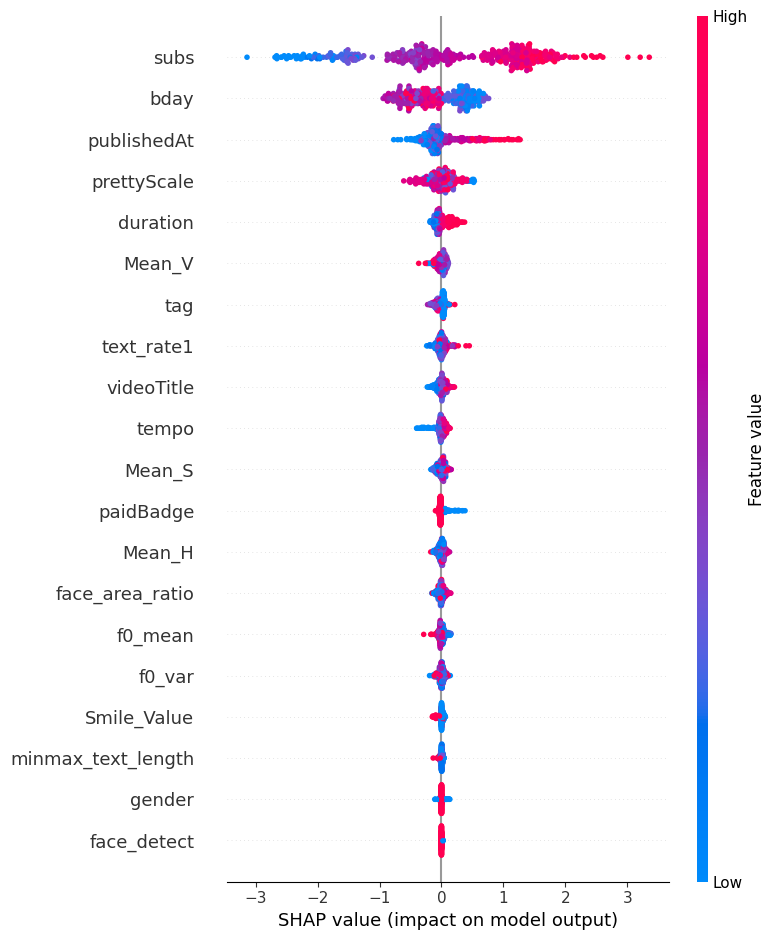

In [36]:
import shap

# 학습된 모델로부터 SHAP 값 계산
explainer = shap.TreeExplainer(opt_xgbc_03)
shap_values = explainer.shap_values(X_test)

# SHAP 요약 플롯 생성
shap.summary_plot(shap_values, X_test)

In [37]:
X_features.columns

Index(['Mean_H', 'Mean_S', 'Mean_V', 'duration', 'paidBadge', 'bday', 'subs',
       'gender', 'prettyScale', 'publishedAt', 'videoTitle', 'tag',
       'face_area_ratio', 'face_detect', 'Smile_Value', 'text_rate1',
       'minmax_text_length', 'text_present', 'tempo', 'f0_mean', 'f0_var'],
      dtype='object')

In [38]:
# 샤프분석 하위 3개 컬럼 드랍

X_features_dropped = X_features.drop(['face_detect', 'gender', 'minmax_text_length'], axis = 1)

In [39]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_features_dropped,
                                                            y_label,
                                                            test_size = 0.2,
                                                            random_state = 42)

In [40]:
# 4회 목적함수는 3회 그대로, 피처만 바꿈

def xgbr_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1200),      # 2000 -> 1500 -> 1200
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15), # 0.001, 0.5 -> 0.01, 0.3 -> 0.01, 0.15
        "max_depth": trial.suggest_int("max_depth", 1, 400),              # 1000 -> 800 -> 400
        "gamma": trial.suggest_float("gamma", 0.001, 5.0),                 # 50 -> 10 -> 5
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10), # 1000 -> 50 -> 10
        "subsample": trial.suggest_float("subsample", 0.5, 0.9),           # 0.2 -> 0.5
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 0.5),           # 1.0 -> 0.8 -> 0.5
        "reg_lambda": trial.suggest_float("reg_lambda", 2.0, 8)            # 10 -> 8 -> 2, 8
    }

    xgbr = XGBRegressor(n_jobs=-1, random_state=12, **params)

    scores = cross_val_score(xgbr,
                             X_train_d,
                             y_train_d,
                             cv=5,
                             scoring=make_scorer(mean_squared_error))

    mse_mean = scores.mean()
    return mse_mean

In [41]:
xgbr_study_04 = optuna.create_study(direction='minimize')
xgbr_study_04.optimize(xgbr_objective, n_trials=100, n_jobs = -1)

[I 2024-06-11 02:09:29,800] A new study created in memory with name: no-name-92892a14-657a-4317-b890-cc4e81d780ea
[I 2024-06-11 02:09:36,339] Trial 0 finished with value: 1.7887602484907856 and parameters: {'n_estimators': 91, 'learning_rate': 0.061715887533982536, 'max_depth': 149, 'gamma': 2.572770718381626, 'min_child_weight': 7, 'subsample': 0.849445433993691, 'colsample_bytree': 0.3083566279321772, 'reg_alpha': 0.2781809097158346, 'reg_lambda': 6.710995885682211}. Best is trial 0 with value: 1.7887602484907856.
[I 2024-06-11 02:09:37,364] Trial 11 finished with value: 1.6051688016212797 and parameters: {'n_estimators': 280, 'learning_rate': 0.10550370738842432, 'max_depth': 71, 'gamma': 3.5974394662950875, 'min_child_weight': 10, 'subsample': 0.6615789272734847, 'colsample_bytree': 0.5829334309588968, 'reg_alpha': 0.2573132208562933, 'reg_lambda': 3.1037291719919358}. Best is trial 11 with value: 1.6051688016212797.
[I 2024-06-11 02:09:37,920] Trial 9 finished with value: 1.614685

In [45]:
# optimize 50번 더 수행 (총 150회)
xgbr_study_04.optimize(xgbr_objective, n_trials=50, n_jobs = -1)

[I 2024-06-11 02:14:36,256] Trial 111 finished with value: 1.5534337023343991 and parameters: {'n_estimators': 400, 'learning_rate': 0.08631117576776935, 'max_depth': 167, 'gamma': 0.7514929820883831, 'min_child_weight': 6, 'subsample': 0.8730060170342567, 'colsample_bytree': 0.8814249111012518, 'reg_alpha': 0.3283214149609318, 'reg_lambda': 5.692150832448914}. Best is trial 21 with value: 1.5122013230847577.
[I 2024-06-11 02:14:45,069] Trial 100 finished with value: 1.5364572142189625 and parameters: {'n_estimators': 289, 'learning_rate': 0.023442257128113528, 'max_depth': 165, 'gamma': 1.4312551878561357, 'min_child_weight': 6, 'subsample': 0.8749292646772763, 'colsample_bytree': 0.8102546802314111, 'reg_alpha': 0.3699932633895124, 'reg_lambda': 5.700918081779461}. Best is trial 21 with value: 1.5122013230847577.
[I 2024-06-11 02:14:46,651] Trial 102 finished with value: 1.5315750982969871 and parameters: {'n_estimators': 310, 'learning_rate': 0.024086184484813068, 'max_depth': 164, 

In [46]:
opt_xgbc_04 = XGBRegressor(n_jobs = -1,
                           random_state = 12,
                           **xgbr_study_04.best_params)

opt_xgbc_04.fit(X_train_d, y_train_d)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7321037215758283, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1.3344214466994786,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01599310530888058,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1185, n_jobs=-1,
             num_parallel_tree=None, random_state=12, ...)

In [47]:
y_pred_04 = opt_xgbc_04.predict(X_test_d)
mse_04 = mean_squared_error(y_test_d, y_pred_04)

mse_04

1.425440708134571

In [48]:
optuna.visualization.plot_parallel_coordinate(xgbr_study_04)

In [49]:
xgbr_study_04.best_params

{'n_estimators': 1185,
 'learning_rate': 0.01599310530888058,
 'max_depth': 8,
 'gamma': 1.3344214466994786,
 'min_child_weight': 4,
 'subsample': 0.7348533026368262,
 'colsample_bytree': 0.7321037215758283,
 'reg_alpha': 0.01266338755008889,
 'reg_lambda': 3.7459214908609453}

In [59]:
import joblib

joblib.dump(opt_xgbc_04, 'opt_xgbc_04.pkl')

['opt_xgbc_04.pkl']

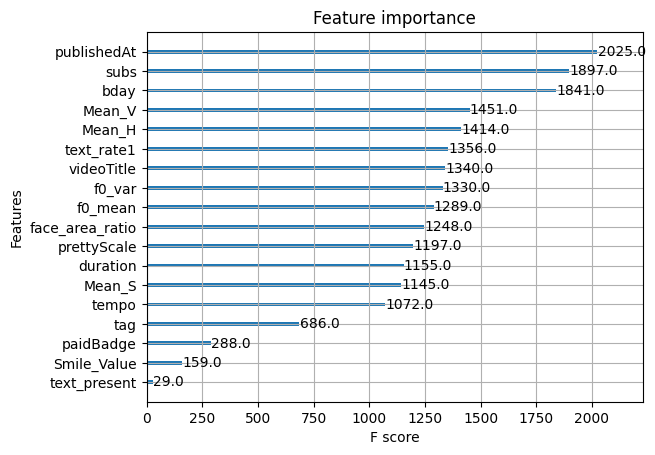

In [120]:
from xgboost import plot_importance
plot_importance(opt_xgbc_04)
plt.show()

# 3. GridSearchCV
* optuna trial 04 참고
* 1.4400735516858156

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

In [61]:
# trial 04에서 하위 3개 컬럼 드랍한 데이터로 gridSearchCV 돌려보겠음

X_features_dropped = X_features.drop(['face_detect', 'gender', 'minmax_text_length'], axis = 1)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_features_dropped,
                                                            y_label,
                                                            test_size = 0.2,
                                                            random_state = 42)

In [63]:
def gs(model=None, parameters=None):
    # grid search
    gs = GridSearchCV(
        model,
        param_grid=parameters,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring=make_scorer(mean_squared_error, greater_is_better=False)  # minimize MSE
    )

    gs.fit(X_train_d, y_train_d)
    print("best_score_ : ", gs.best_score_)
    print("-------------- best_params --------------")
    print(gs.best_params_)
    print("-----------------------------------------")

    gs_best = gs.best_estimator_
    gs_ypred = gs_best.predict(X_test_d)
    gs_mse = mean_squared_error(y_test_d, gs_ypred)

    print("Best MSE : ", gs_mse)
    return gs_best, gs_mse


In [64]:
xgbr_study_04.best_params

{'n_estimators': 1185,
 'learning_rate': 0.01599310530888058,
 'max_depth': 8,
 'gamma': 1.3344214466994786,
 'min_child_weight': 4,
 'subsample': 0.7348533026368262,
 'colsample_bytree': 0.7321037215758283,
 'reg_alpha': 0.01266338755008889,
 'reg_lambda': 3.7459214908609453}

In [67]:
### 옵튜나 파라미터 참고해서 GridSearchCV 돌려보기

parameters ={
    "subsample" : [0.7, 0.8],
    "n_estimators" : [500, 1000],
    "max_depth":[6, 8],
    "gamma":[1.0, 1.3],
    "min_child_weight":[3, 4],
    "colsample_bytree":[0.7, 0.75],
    "learning_rate":[0.01, 0.05],
    'reg_alpha': [0.01, 0.1],
    'reg_lambda': [3, 4]
}

xgbr = XGBRegressor(n_jobs = -1, random_state = 12)
xgbr_best, xgbr_mse = gs(model = xgbr, parameters = parameters)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
best_score_ :  -1.505437552080328
-------------- best_params --------------
{'colsample_bytree': 0.7, 'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 1000, 'reg_alpha': 0.1, 'reg_lambda': 3, 'subsample': 0.7}
-----------------------------------------
Best MSE :  1.4400735516858156


In [70]:
xgbr_mse

1.4400735516858156

In [71]:
joblib.dump(xgbr_best, 'xgbr_best.pkl')

['xgbr_best.pkl']

In [72]:
xgbr_best

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=12, ...)

In [73]:
opt_xgbc_04

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7321037215758283, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1.3344214466994786,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01599310530888058,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1185, n_jobs=-1,
             num_parallel_tree=None, random_state=12, ...)

# 4. xgb_trial 05, 06
* 05 : 옵튜나 하이퍼파라미터 4회 그대로, optimize 횟수 늘리기 -> 1.4227746540687654
* 06 : 옵튜나 하이퍼파라미터 4회 그대로, 컬럼 2개 드랍 (text_present) -> 1.3663304676919281

In [81]:
# 4회 목적함수는 3회 그대로, 피처만 바꿈

def xgbr_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1200),      # 2000 -> 1500 -> 1200
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15), # 0.001, 0.5 -> 0.01, 0.3 -> 0.01, 0.15
        "max_depth": trial.suggest_int("max_depth", 1, 400),              # 1000 -> 800 -> 400
        "gamma": trial.suggest_float("gamma", 0.001, 5.0),                 # 50 -> 10 -> 5
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10), # 1000 -> 50 -> 10
        "subsample": trial.suggest_float("subsample", 0.5, 0.9),           # 0.2 -> 0.5
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 0.5),           # 1.0 -> 0.8 -> 0.5
        "reg_lambda": trial.suggest_float("reg_lambda", 2.0, 8)            # 10 -> 8 -> 2, 8
    }

    xgbr = XGBRegressor(n_jobs=-1, random_state=12, **params)

    scores = cross_val_score(xgbr,
                             X_train_d,
                             y_train_d,
                             cv=5,
                             scoring=make_scorer(mean_squared_error))

    mse_mean = scores.mean()
    return mse_mean

In [82]:
xgbr_study_04_re = optuna.create_study(direction='minimize')
xgbr_study_04_re.optimize(xgbr_objective, n_trials=500, n_jobs = -1)

[I 2024-06-11 03:00:34,915] A new study created in memory with name: no-name-e05430c4-2b80-4d65-ab41-e95db00e6d9e
[I 2024-06-11 03:00:39,293] Trial 1 finished with value: 1.7072393653276705 and parameters: {'n_estimators': 61, 'learning_rate': 0.06306590583448582, 'max_depth': 190, 'gamma': 3.616962617716972, 'min_child_weight': 7, 'subsample': 0.6115313673615849, 'colsample_bytree': 0.5080544297866671, 'reg_alpha': 0.31129328486181146, 'reg_lambda': 4.559786957357062}. Best is trial 1 with value: 1.7072393653276705.
[I 2024-06-11 03:00:43,494] Trial 9 finished with value: 1.715124930129134 and parameters: {'n_estimators': 102, 'learning_rate': 0.02734990009358422, 'max_depth': 276, 'gamma': 1.3745373427182586, 'min_child_weight': 10, 'subsample': 0.5643726676559858, 'colsample_bytree': 0.768478751100566, 'reg_alpha': 0.14291403091549415, 'reg_lambda': 6.392701038969491}. Best is trial 1 with value: 1.7072393653276705.
[I 2024-06-11 03:00:46,666] Trial 7 finished with value: 1.62651510

In [83]:
opt_xgbc_04_re = XGBRegressor(n_jobs = -1,
                              random_state = 12,
                              **xgbr_study_04_re.best_params)

opt_xgbc_04_re.fit(X_train_d, y_train_d)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8708567081455826, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1.3080057615044736,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.012355284489736744,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=367, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=899, n_jobs=-1,
             num_parallel_tree=None, random_state=12, ...)

In [84]:
y_pred_04_re = opt_xgbc_04_re.predict(X_test_d)
mse_04_re = mean_squared_error(y_test_d, y_pred_04_re)

mse_04_re

1.4227746540687654

In [85]:
joblib.dump(opt_xgbc_04_re, 'opt_xgbc_04_re.pkl')

['opt_xgbc_04_re.pkl']

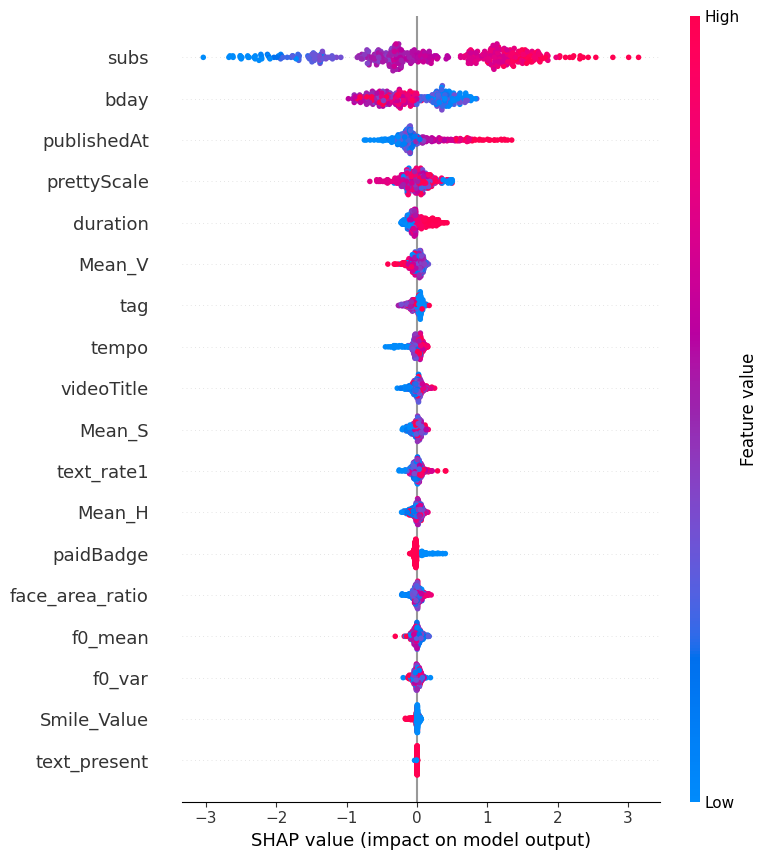

In [86]:
explainer = shap.TreeExplainer(opt_xgbc_04_re)
shap_values = explainer.shap_values(X_test_d)

# SHAP 요약 플롯 생성
shap.summary_plot(shap_values, X_test_d)

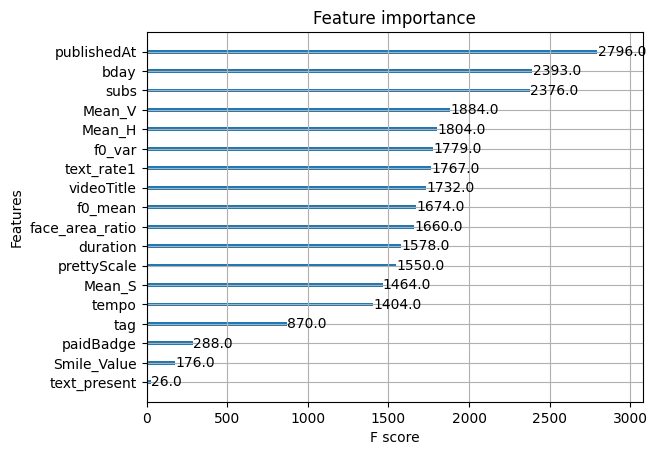

In [121]:
plot_importance(opt_xgbc_04_re)
plt.show()

In [98]:
import numpy as np

pd.concat([X_features_dropped, y_label], axis = 1).corr()

,Mean_H,Mean_S,Mean_V,duration,paidBadge,bday,subs,prettyScale,publishedAt,videoTitle,tag,face_area_ratio,Smile_Value,text_rate1,text_present,tempo,f0_mean,f0_var,viewCount_log
Mean_H,1.000000,-0.234792,-0.047873,-0.007127,0.027743,-0.044329,0.089595,0.161564,-0.056260,-0.007532,0.052455,-0.134822,0.086021,0.071703,0.064757,0.021450,0.063508,0.097714,0.040748
Mean_S,-0.234792,1.000000,-0.182423,-0.030739,-0.036027,-0.024317,0.010294,-0.089915,0.126266,0.028468,-0.078124,0.144502,-0.033074,-0.176176,-0.123071,0.002767,0.086706,-0.017154,0.123583
Mean_V,-0.047873,-0.182423,1.000000,-0.067482,-0.092315,0.094665,-0.061897,-0.150567,0.150230,0.034944,0.064514,0.110337,-0.101048,0.037272,0.055504,-0.082180,0.051911,0.023375,-0.097302
duration,-0.007127,-0.030739,-0.067482,1.000000,0.026333,0.048887,0.054128,0.120800,-0.090501,0.138981,0.088348,0.002940,0.102494,0.126690,0.095205,0.040458,-0.131950,0.009313,0.019977
paidBadge,0.027743,-0.036027,-0.092315,0.026333,1.000000,-0.144978,0.078855,-0.070946,-0.172333,-0.022424,-0.128990,-0.038032,0.148736,0.078312,0.177964,0.054550,-0.111693,0.003204,0.056215
bday,-0.044329,-0.024317,0.094665,0.048887,-0.144978,1.000000,0.215614,0.120633,0.150886,-0.055928,0.107636,0.014449,-0.107744,-0.026195,-0.149724,-0.084693,0.048753,0.056869,-0.075232
subs,0.089595,0.010294,-0.061897,0.054128,0.078855,0.215614,1.000000,0.206366,-0.020215,-0.017932,-0.068310,0.099457,0.082013,-0.067739,-0.132025,0.044530,0.006278,0.058412,0.613455
prettyScale,0.161564,-0.089915,-0.150567,0.120800,-0.070946,0.120633,0.206366,1.000000,-0.056108,-0.003273,0.122480,-0.027540,-0.020320,-0.007832,-0.153453,0.013692,0.159222,0.122868,0.028826
publishedAt,-0.056260,0.126266,0.150230,-0.090501,-0.172333,0.150886,-0.020215,-0.056108,1.000000,0.030613,0.200327,-0.073994,-0.092744,-0.055187,-0.120891,-0.114625,0.143626,0.048665,0.131195
videoTitle,-0.007532,0.028468,0.034944,0.138981,-0.022424,-0.055928,-0.017932,-0.003273,0.030613,1.000000,0.056260,-0.036930,0.070802,0.022353,0.027545,0.024482,0.089690,0.061650,0.015318


In [122]:
# text_present 컬럼 1개 드랍 (text_present)

X_features_dropped_02 = X_features_dropped.drop(['text_present', 'Smile_Value'], axis = 1)
X_train_dd, X_test_dd, y_train_dd, y_test_dd = train_test_split(X_features_dropped_02,
                                                                y_label,
                                                                test_size = 0.2,
                                                                random_state = 24)

In [123]:
# 6회 목적함수는 4회 그대로, 피처만 바꿈

def xgbr_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1200),      # 2000 -> 1500 -> 1200
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15), # 0.001, 0.5 -> 0.01, 0.3 -> 0.01, 0.15
        "max_depth": trial.suggest_int("max_depth", 1, 400),              # 1000 -> 800 -> 400
        "gamma": trial.suggest_float("gamma", 0.001, 5.0),                 # 50 -> 10 -> 5
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10), # 1000 -> 50 -> 10
        "subsample": trial.suggest_float("subsample", 0.5, 0.9),           # 0.2 -> 0.5
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 0.5),           # 1.0 -> 0.8 -> 0.5
        "reg_lambda": trial.suggest_float("reg_lambda", 2.0, 8)            # 10 -> 8 -> 2, 8
    }

    xgbr = XGBRegressor(n_jobs=-1, random_state=12, **params)

    scores = cross_val_score(xgbr,
                             X_train_dd,
                             y_train_dd,
                             cv=5,
                             scoring=make_scorer(mean_squared_error))

    mse_mean = scores.mean()
    return mse_mean

In [124]:
xgbr_study_06 = optuna.create_study(direction='minimize')
xgbr_study_06.optimize(xgbr_objective, n_trials=100, n_jobs = -1)

[I 2024-06-11 05:50:02,854] A new study created in memory with name: no-name-864ee186-c931-4edf-94bf-e30dcb050108
[I 2024-06-11 05:50:07,323] Trial 7 finished with value: 1.5991061261619963 and parameters: {'n_estimators': 89, 'learning_rate': 0.08937314484394959, 'max_depth': 11, 'gamma': 4.147580455682982, 'min_child_weight': 2, 'subsample': 0.6067852189037928, 'colsample_bytree': 0.556659999561603, 'reg_alpha': 0.050356232993482575, 'reg_lambda': 2.6596820465149453}. Best is trial 7 with value: 1.5991061261619963.
[I 2024-06-11 05:50:07,961] Trial 8 finished with value: 1.5453448143484676 and parameters: {'n_estimators': 66, 'learning_rate': 0.08086761172682462, 'max_depth': 51, 'gamma': 2.513624231049544, 'min_child_weight': 8, 'subsample': 0.7016576429670506, 'colsample_bytree': 0.8411562783368194, 'reg_alpha': 0.2698860615692553, 'reg_lambda': 6.218194080066642}. Best is trial 8 with value: 1.5453448143484676.
[I 2024-06-11 05:50:08,867] Trial 12 finished with value: 3.7771079727

In [128]:
# optimize 100회 더

xgbr_study_06.optimize(xgbr_objective, n_trials=100, n_jobs = -1)

[I 2024-06-11 05:53:51,664] Trial 107 finished with value: 1.5075758759992552 and parameters: {'n_estimators': 1038, 'learning_rate': 0.013037784774657887, 'max_depth': 333, 'gamma': 2.5402235536540916, 'min_child_weight': 4, 'subsample': 0.8843465228314448, 'colsample_bytree': 0.7235635351083424, 'reg_alpha': 0.23599371574192535, 'reg_lambda': 4.4376528814533005}. Best is trial 96 with value: 1.4949535166239756.
[I 2024-06-11 05:53:55,185] Trial 101 finished with value: 1.501872117255644 and parameters: {'n_estimators': 1054, 'learning_rate': 0.0132690194622254, 'max_depth': 312, 'gamma': 1.7495031555335847, 'min_child_weight': 5, 'subsample': 0.8832613728234048, 'colsample_bytree': 0.7224557386542626, 'reg_alpha': 0.23337311317329335, 'reg_lambda': 4.425514232161591}. Best is trial 96 with value: 1.4949535166239756.
[I 2024-06-11 05:53:56,791] Trial 110 finished with value: 1.4965002873061863 and parameters: {'n_estimators': 1059, 'learning_rate': 0.01248620269776331, 'max_depth': 33

In [132]:
opt_xgbc_06 = XGBRegressor(n_jobs = -1,
                           random_state = 24,
                           **xgbr_study_06.best_params)

opt_xgbc_06.fit(X_train_dd, y_train_dd)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8688943355878658, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.04478682441116197,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.010245504940868958,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=69, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=974, n_jobs=-1,
             num_parallel_tree=None, random_state=24, ...)

In [133]:
y_pred_06 = opt_xgbc_06.predict(X_test_dd)
mse_06 = mean_squared_error(y_test_dd, y_pred_06)

mse_06

1.3663304676919281

In [134]:
joblib.dump(opt_xgbc_06, 'opt_xgbc_06.pkl')

['opt_xgbc_06.pkl']

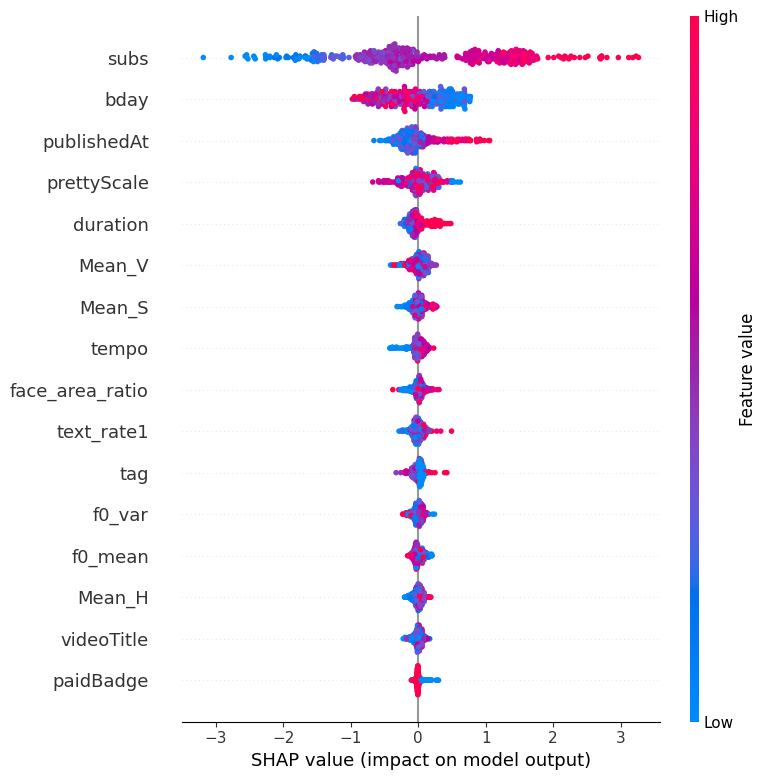

In [137]:
explainer = shap.TreeExplainer(opt_xgbc_06)
shap_values = explainer.shap_values(X_test_dd)

# SHAP 요약 플롯 생성
shap.summary_plot(shap_values, X_test_dd)

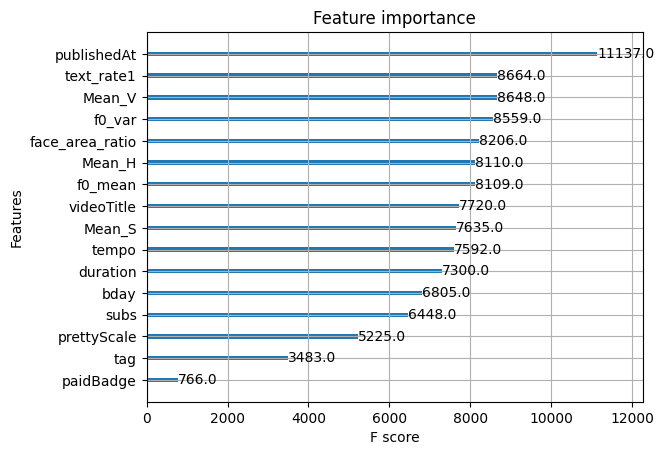

In [138]:
plot_importance(opt_xgbc_06)
plt.show()

# 5. prediction

In [170]:
X_test_dd.head()

,Mean_H,Mean_S,Mean_V,duration,paidBadge,bday,subs,prettyScale,publishedAt,videoTitle,tag,face_area_ratio,text_rate1,tempo,f0_mean,f0_var
1056,0.353333,0.177083,0.738462,0.763636,1,0.723039,0.498438,0.674074,0.116474,0.180851,0.00,0.067883,0.000000,0.547170,0.125366,0.075043
109,0.060000,0.312500,0.794872,0.981818,1,0.541141,0.779173,0.622222,0.053411,0.276596,0.32,0.681944,0.063758,0.690476,0.241296,0.450482
1867,0.340000,0.708333,0.676923,1.000000,1,0.118873,0.600843,0.540741,0.147362,0.968085,0.00,0.000000,0.107240,0.568627,0.354143,0.379677
1817,0.206667,0.645833,0.779487,0.527273,1,0.061800,0.653933,0.000000,0.111326,0.127660,0.00,1.000000,0.035424,0.852941,0.148294,0.190686
322,0.193333,0.635417,0.553846,0.709091,1,0.441877,0.585686,0.614815,0.017375,0.882979,0.00,0.658190,0.090759,0.644444,0.416378,0.542980


In [171]:
preds = X_test_dd.copy()

preds['y_predict'] = y_pred_06
preds['y_truth'] = y_test_dd

In [172]:
order = (preds['y_predict'] - preds['y_truth']).apply(abs).sort_values(ascending=False)
order

133     4.699828
1201    3.996317
91      3.962069
2006    3.404515
1637    3.354761
          ...   
2143    0.014377
1468    0.012207
1113    0.010324
1431    0.009416
1084    0.003816
Length: 437, dtype: float64

In [176]:
preds.to_csv("preds.csv")

In [174]:
preds.loc[order.head(10).index]

,Mean_H,Mean_S,Mean_V,duration,paidBadge,bday,subs,prettyScale,publishedAt,videoTitle,tag,face_area_ratio,text_rate1,tempo,f0_mean,f0_var,y_predict,y_truth
133,0.053333,0.270833,0.282051,0.963636,1,0.244223,0.576288,0.740741,0.232947,0.361702,0.440000,0.184848,0.161531,0.707317,0.291262,0.281237,9.207687,13.907515
1201,0.626667,0.427083,0.538462,0.418182,1,0.307948,0.704859,0.740741,0.370013,0.202128,0.000000,0.000000,0.197140,0.420290,0.633594,1.000000,10.809760,14.806077
91,0.540000,0.343750,0.892308,0.581818,0,0.207633,0.436768,0.511111,0.407979,0.031915,0.000000,0.000000,0.018379,0.852941,0.173376,0.205472,9.697855,13.659924
2006,0.680000,0.354167,0.723077,0.654545,1,0.118522,0.599050,0.570370,0.290862,0.159574,0.000000,0.000000,0.121517,0.690476,0.312190,0.451471,9.673303,13.077818
1637,0.553333,0.479167,0.846154,0.981818,1,0.425420,0.491186,0.548148,0.283140,0.372340,0.266295,0.044049,0.109028,0.783784,0.336677,0.515605,9.045120,5.690359
409,0.520000,0.406250,0.953846,0.872727,1,0.827731,0.557694,0.681481,0.222008,0.297872,0.266295,0.000000,0.076712,0.000000,0.342686,0.914496,6.945743,10.225426
2164,0.340000,0.729167,0.687179,0.672727,1,0.129552,0.574467,0.718519,0.000000,0.446809,0.000000,0.579985,0.047456,0.568627,0.378443,0.354785,9.260461,6.263398
1139,0.153333,0.708333,0.466667,1.000000,1,0.237570,0.689254,0.777778,0.156371,0.797872,0.360000,0.474689,0.103032,0.674419,0.163180,0.193955,12.162807,15.042836
918,0.140000,0.645833,0.441026,1.000000,0,0.090861,0.681384,0.740741,0.017375,0.542553,0.000000,0.184953,0.034653,0.659091,0.327208,0.378182,10.612445,13.459087
472,0.240000,0.452925,0.497436,1.000000,0,0.139006,0.607166,0.503704,0.086229,0.500000,0.000000,0.402158,0.082226,0.527273,0.264216,0.527019,11.372002,14.198861


In [175]:
data.loc[order.head(10).index]

,videoId,Mean_H,Mean_S,Mean_V,channelId,duration,viewCount,paidBadge,bday,subs,...,viewCount_log,face_area_ratio,face_detect,Smile_Value,text_rate1,minmax_text_length,text_present,tempo,f0_mean,f0_var
133,6Ef3gVpmBWs,0.053333,0.270833,0.282051,UCj83T5taUG2jr2h0aPSPA3g,0.963636,1096369,1,0.244223,0.576288,...,13.907515,0.184848,1,0,0.161531,0.038462,1.0,0.707317,0.291262,0.281237
1201,5GtprHjjKuo,0.626667,0.427083,0.538462,UCiBZgMVPhLClk7qdPhfdjdA,0.418182,2692758,1,0.307948,0.704859,...,14.806077,0.000000,0,0,0.197140,0.192308,1.0,0.420290,0.633594,1.000000
91,3t0HgVurLFI,0.540000,0.343750,0.892308,UCVT-Ez_wJP4NLnDs3n-lQaQ,0.581818,855912,0,0.207633,0.436768,...,13.659924,0.000000,0,0,0.018379,0.038462,1.0,0.852941,0.173376,0.205472
2006,rZS-app6klI,0.680000,0.354167,0.723077,UCo9OPeVJL5hgPtwxUTEBgSA,0.654545,478215,1,0.118522,0.599050,...,13.077818,0.000000,0,0,0.121517,0.038462,1.0,0.690476,0.312190,0.451471
1637,UfNSmtlAXFU,0.553333,0.479167,0.846154,UCaxyM3FMUgdIcP0iPZl0FGg,0.981818,295,1,0.425420,0.491186,...,5.690359,0.044049,1,0,0.109028,0.076923,1.0,0.783784,0.336677,0.515605
409,MHND51W6liE,0.520000,0.406250,0.953846,UCmfYQLSbkiEKkk89ylUg08w,0.872727,27595,1,0.827731,0.557694,...,10.225426,0.000000,0,0,0.076712,0.115385,1.0,0.000000,0.342686,0.914496
2164,JdlsCDq44iQ,0.340000,0.729167,0.687179,UC7R377JtSnWUAH3bIDX3mZw,0.672727,524,1,0.129552,0.574467,...,6.263398,0.579985,1,0,0.047456,0.038462,1.0,0.568627,0.378443,0.354785
1139,1Q8VC4RS628,0.153333,0.708333,0.466667,UCtmcJ2mtRTlVd_AfGu04RiA,1.000000,3412090,1,0.237570,0.689254,...,15.042836,0.474689,1,0,0.103032,0.115385,1.0,0.674419,0.163180,0.193955
918,pF_LNdPhM0E,0.140000,0.645833,0.441026,UCihxURVPSelRMndC-0HdIcg,1.000000,700175,0,0.090861,0.681384,...,13.459087,0.184953,1,0,0.034653,0.076923,1.0,0.659091,0.327208,0.378182
472,QAMXKxtpnjE,0.240000,0.452925,0.497436,UCR8th9vv4cSnfoY-Gx5hnbA,1.000000,1467191,0,0.139006,0.607166,...,14.198861,0.402158,1,1,0.082226,0.000000,1.0,0.527273,0.264216,0.527019
